## Calculating the distance to the Palomar 13 globular cluster (v2.0)

Author: Luke Bischoff<br>
Created: 30 DECEMBER 2020 16:15<br>
Updated: 18 DECEMBER 2020 12:47

##### Introduction
This document aims to measure the distance to the Palomar 13 (PAL13) globular cluster in the Milky Way Galaxy. This is achieved by using RR Lyrae variable stars within the cluster and analysing their apparent magnitudes and periods in the form of a PL relation. A plot of the RR Lyrae's individual average apparent magnitude against their period enables a PL relation to be fit to the data and compared to a calibrated PL relation, which is based in absolute magnitudes. The distance can then be calculated from the distance modulus.
##### Contents
1. List of python imports and modules<br>
2. User defined functions<br>
3. Initialisation and options<br>
3a. Initialisation: choosing globular cluster and channel information<br>
3b. Options: choosing photometry parameters<br>
4. Master source list: creating a list of all detected stars in the main frames<br>
5. Photometry: performing photometry on epoch data and matching to master source list (optimised for PSF only)<br>
6. Raw light curves: constructs raw light curves for identified RR Lyraes<br>
7. GLOESS analysis: constructs light curves with a smoothing function and returns average magnitudes and uncertainties<br>
8. PL relations: fits PL relations for the data in each channel and returns distances<br>

##### Import list

In [65]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from gloess_plot import GLOESSpy
from scipy.optimize import curve_fit
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join, vstack
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.io.votable import parse_single_table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from astroquery.irsa_dust import IrsaDust
from matplotlib import rc
from matplotlib.colors import LogNorm

#plt.rcParams.update({'font.size': 18})
#rc('text', usetex=True)
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

In [2]:
## COORDINATE CONVERSION ##
def Coord_Conv(header, x_list, y_list):
    # CONVERTS COORDINATES IN X, Y TO RIGHT ASCENSION AND DECLINATION USING ICRS COORDINATES
    # header: INPUT HEADER REFERENCE TO OBTAIN WCS
    # x_list, y_list: LIST OF X AND Y COORDINATES TO BE CONVERTED
    w = wcs.WCS(header)
    coord = np.transpose((x_list, y_list))
    world = w.wcs_pix2world(coord, 0)
    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    return ra, dec, c

In [86]:
## INPUT DATA PATHS ##

cluster_input = 'PAL13'

if cluster_input == 'PAL5':
    epoch_path = 'PAL5_data/*/'
    master_path = 'PAL5_data/PAL5/'
    general_path = 'PAL5_data/'
elif cluster_input == 'PAL13':
    epoch_path = 'PAL13_data/*/'
    master_path = 'PAL13_data/PAL13/'
    general_path = 'PAL13_data/'
elif cluster_input == 'IC4499':
    epoch_path = 'IC4499_data/*/'
    master_path = 'IC4499_data/IC4499/'
    general_path = 'IC4499_data/'
else:
    raise ValueError('Cluster not found: input clusters `PAL5`, `PAL13` or `IC4499` only!')

## CHANNEL ##

ch1_list = [0, 1, 2, 4]
ch2_list = [0, 1, 2, 3]

channel = '4p5um'

if channel == '3p6um':
    aper_corr = 1.1233            # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80             # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02              # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
    rr_list   = ch1_list
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
    rr_list   = ch2_list
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PHOTOMETRY PARAMETERS AND OPTIONS ##

fwhm = 5.               # APPROX. FULL-WIDTH AT HALF-MAXIMUM FOR SAMPLE OF STARS
sigma = 6.              # SIGMA VALUE FOR MASTER STAR LIST AND PHOTOMETRY STAR DETECTION AND SIGMA-CLIPPING
sigma_epsf = 50.        # SIGMA VALUE FOR ePSF MODEL STAR DETECTION
r_ap = 6.               # APERTURE RADIUS AROUND DETECTED SOURCE
r_in = 6.               # INNER RADIUS FOR STAR ANNULI
r_out = 14.             # OUTER RADIUS FOR STAR ANNULI
roundlo = -0.5          # ROUND VALUE FOR STAR DETECTION ALGORITHM
roundhi = +0.5
sharphi = 0.9           # SHARP VALUE FOR PHOTOMETRY STAR DETECTION
sharphi_model = 0.8     # SHARP VALUE FOR ePSF MODEL STAR DETECTION
rrl_rad = 20            # REGION AROUND KNOWN RRL

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'

##### Build PSF model
Build the PSF model for the channel first, then create the master list by considering only the area around known RR Lyraes.

FITS file information:
FILE = PAL13_data/PAL13/PAL13_4p5um.fits



Number of ePSF sources found = 42

Number of refined ePSF sources = 25



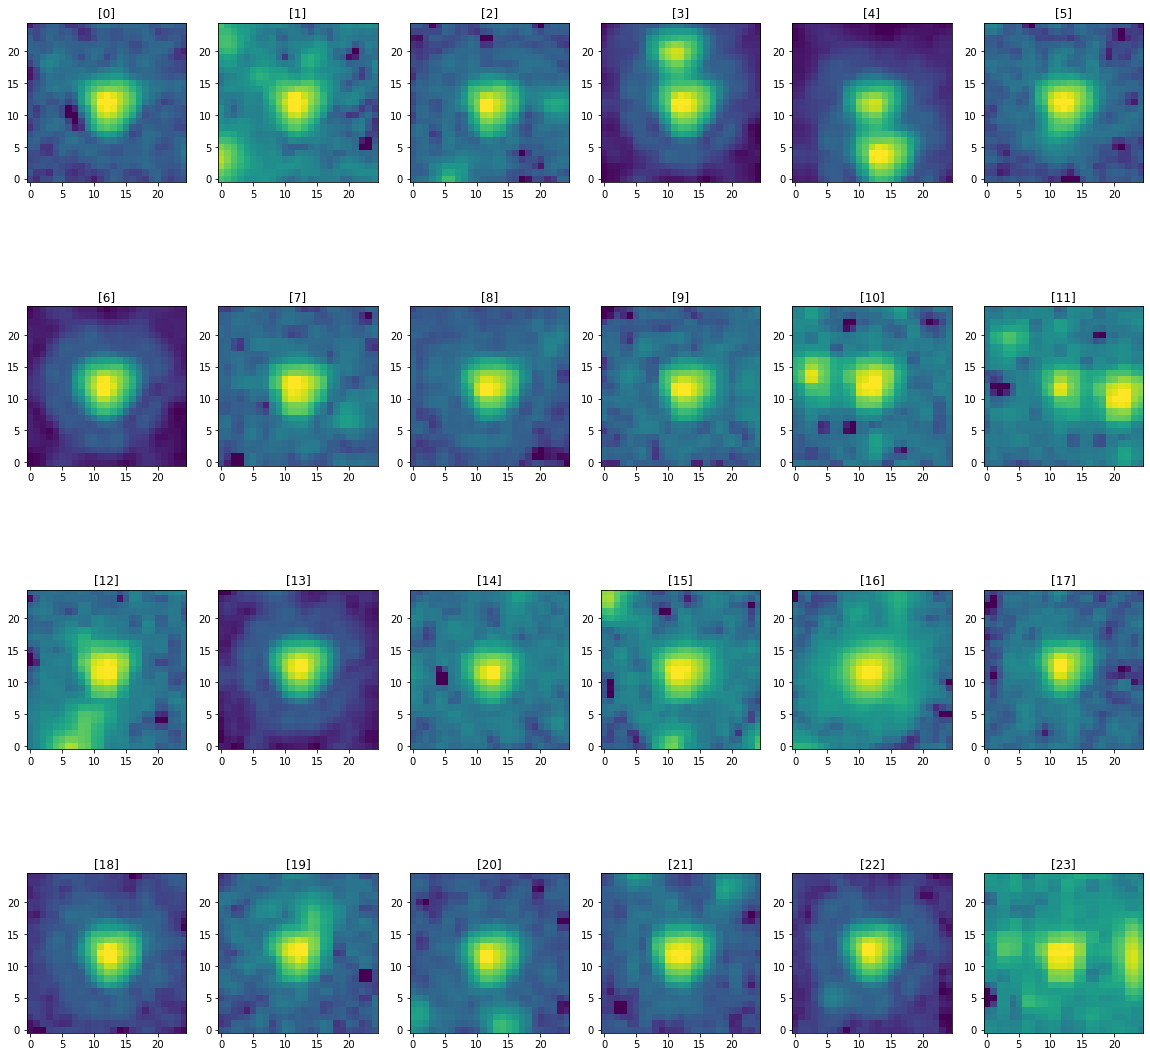

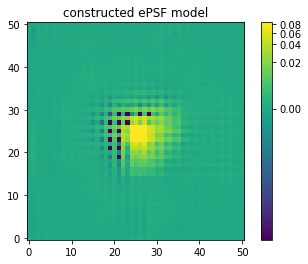

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
3 4 10 11 12 20 23


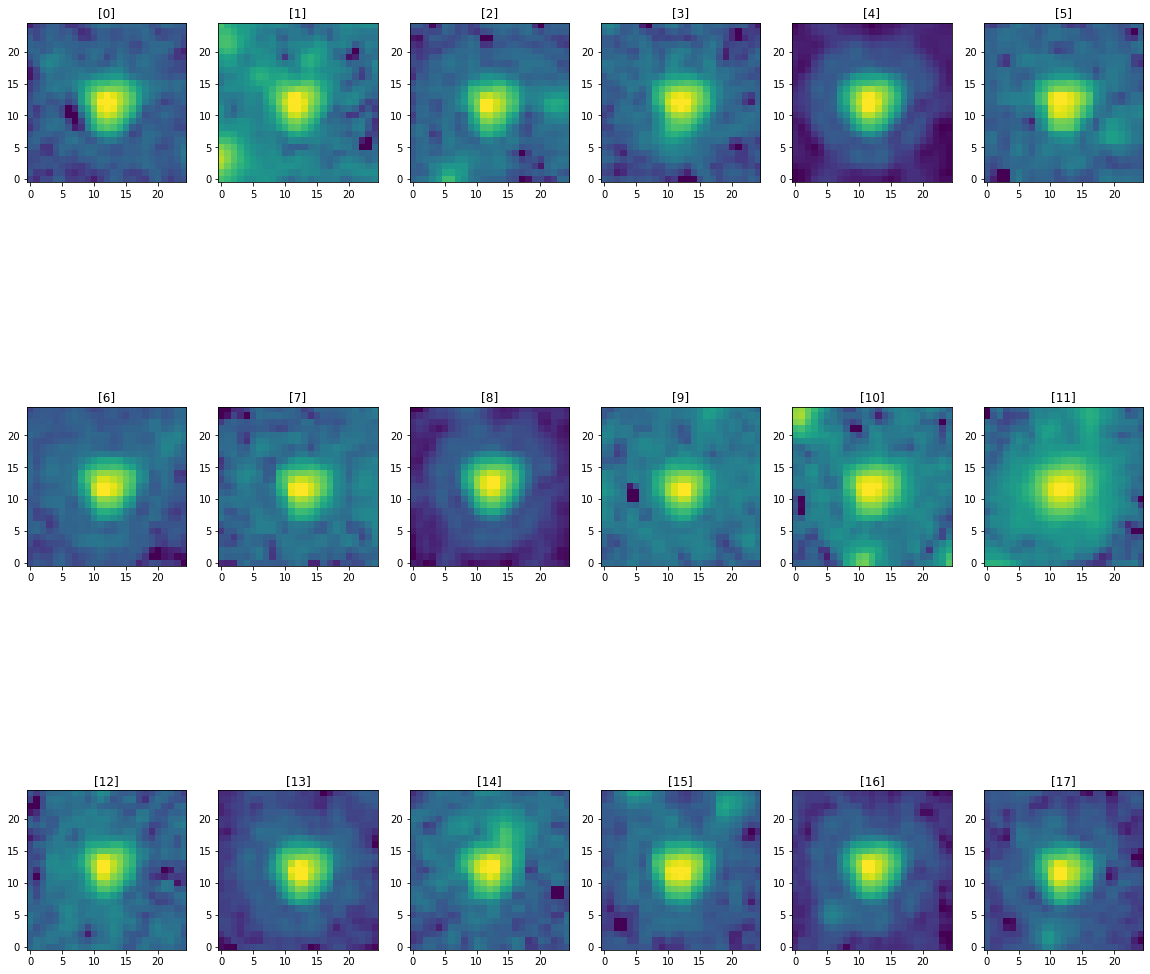

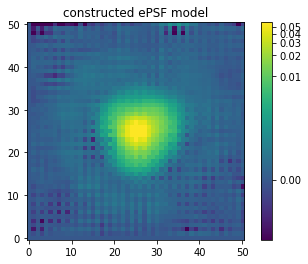

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



In [87]:
epsf_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(epsf_file) as hdr_list:
    epsf_hdr = hdr_list[0].header
    if channel == '4p5um':
        counts = epsf_hdr['EXPTIME'] / 0.1469
    else:
        counts = epsf_hdr['EXPTIME'] / epsf_hdr['FLUXCONV']
    im_data = fits.getdata(epsf_file, ext = 0)
    epsf_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(epsf_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(epsf_data, sigma = sigma) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(epsf_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## MASK BRIGHT ZONE IN CHANNEL 2 FOR EPSF ##

if channel == '4p5um':
    x_mask = epsf_sources['xcentroid']
    y_mask = epsf_sources['ycentroid']
    del epsf_sources
    xlim = 1150
    epsf_mask = (x_mask < xlim)
    epsf_sources = Table()
    epsf_sources['xcentroid'] = x_mask[epsf_mask]
    epsf_sources['ycentroid'] = y_mask[epsf_mask]

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (epsf_data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (epsf_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = epsf_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

##### Master source list
Master source list considering only a region around the known stars

In [88]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as hdr_list:
    m_hdr = hdr_list[0].header
    if channel == '4p5um':
        counts = m_hdr['EXPTIME'] / 0.1469
    else:
        counts = m_hdr['EXPTIME'] / m_hdr['FLUXCONV']
    w = wcs.WCS(m_hdr)
    im_data = fits.getdata(master_file, ext = 0)
    m_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))
    
## IMPORT RAW CATALOGUE LIST FOR PAL13 OF KNOWN RRLs ##

cat_file = 'CCVS_data/CCVS_'+cluster_input+'_RRLs_data.txt'
df_cat = ascii.read(cat_file, delimiter = ',', data_start = 1)

## CONVERT COORDINATES TO RA, DEC IN CATALOGUE ##

df_cat['ra_deg'] = str('null')
df_cat['dec_deg'] = str('null')
    
for col in df_cat.itercols():
    if col.dtype.kind in 'SU':
        df_cat.replace_column(col.name, col.astype('object'))
            
for i in range(len(df_cat)):
    ra_hms = Angle(df_cat['ra'][i], u.hour)
    df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
for i in range(len(df_cat)):
    dec_hms = Angle(df_cat['dec'][i], u.degree)
    df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)

## WRITE TO NEW FILE : USE IN LIGHT CURVES ##

df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster_input), format = 'csv', overwrite = True)

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster_input+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster_input))
print(rrl_cat); print('\n')

## GENERATE A MASTER LIST FOR THE KNOWN STARS IN SELECTED CHANNEL ##

for i in range(len(rrl_cat)):
    if i in rr_list:
        rrl_ra = rrl_cat['ra_deg'][i]
        rrl_dec = rrl_cat['dec_deg'][i]
        coord_rrl = SkyCoord(rrl_ra, rrl_dec, frame='icrs', unit='deg')
        
        ## OBTAIN PIXEL COORD AND X, Y VALUES
        pix_rrl = w.world_to_pixel(coord_rrl)
        
        rrl_x = int(pix_rrl[0])
        rrl_y = int(pix_rrl[1])
        
        ## CREATE REGION FROM MASTER FRAME
        m_region = m_data[rrl_y - rrl_rad : rrl_y + rrl_rad, rrl_x - rrl_rad : rrl_x + rrl_rad]
        
        ## SOURCE DETECTION ##

        mean_m, median_m, std_m = sigma_clipped_stats(m_region, sigma = sigma)
        
        master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        master_sources = master_daofind(m_region)
        
        ## RENAME STAR LIST HEADERS ##

        master_sources['xcentroid'].name = 'x_0'
        master_sources['ycentroid'].name = 'y_0'
        master_sources['id'].name = 'master_id'
        
        ## PSF ROUTINE ON MASTER LIST ##

        daogroup = DAOGroup(crit_separation = sigma * fwhm)

        data_psf_m = np.nan_to_num(m_region, nan = 1**-7)

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        pos_init_m = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 2,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        m_phot = PSF_photometry(image = data_psf_m, init_guesses = pos_init_m)
        residual_image = PSF_photometry.get_residual_image()
        
        ## COORDINATE CONVERSION ##

        master_list = copy.copy(m_phot)
        del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc']
        master_list['id'].name = 'phot_id'
        
        ## ADJUST PIXEL COORDS TO NATIVE VALUE ##
        
        x_native = pix_rrl[0] + master_list['x_0'] - rrl_rad
        y_native = pix_rrl[1] + master_list['y_0'] - rrl_rad
        master_list['x_0'] = x_native
        master_list['y_0'] = y_native

        master_list['master_id'] = int(0)
        for j in range(len(master_list)):
            master_list['master_id'][j] = j

        del master_list['phot_id']
        new_order = ['master_id', 'x_0', 'y_0', 'iter_detected']
        master_list = master_list[new_order]

        ra_m, dec_m, c_m = Coord_Conv(m_hdr, master_list['x_0'], master_list['y_0'])

        master_list['ra'] = ra_m
        master_list['dec'] = dec_m

        ## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

        master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_master_list_{1}_RRL{2}.txt'.format(cluster_input, channel, i), format = 'csv', overwrite = True)

master_list.show_in_notebook()

FITS file information:
FILE = PAL13_data/PAL13/PAL13_4p5um.fits

RR Lyrae catalogue for PAL13:

   id           ra          dec  period type   ra_deg  dec_deg
0   0  23:06:41.53  +12:46:58.9  0.5382  RR0  346.673  12.7830
1   1  23:06:44.47  +12:46:16.1  0.5971  RR0  346.685  12.7711
2   2  23:06:43.14  +12:46:47.8  0.5782  RR0  346.680  12.7799
3   3  23:06:48.83  +12:41:22.3  0.5751  RR0  346.703  12.6895
4   4  23:06:37.28  +12:49:27.5  7.2600  RR0  346.655  12.8243




idx,master_id,x_0,y_0,iter_detected,ra,dec
0,0,846.4720483987265,407.0057609785664,1,346.7046537124247,12.693425777479877
1,1,881.365105723828,407.0414803053918,1,346.7069199236204,12.68804677422952
2,2,865.0367640000716,422.73205813055847,1,346.70337848883776,12.689566188872725
3,3,846.7070549627705,441.8251659627653,1,346.6991692697873,12.691177811953047
4,4,846.7886255746913,412.81955818700743,2,346.7037560258199,12.693007707022652
5,5,846.1366826068113,426.80903094480925,2,346.70150392666767,12.692219550354965


##### Photometry
As before, photometry on individual epochs but using just the regions around known RRLs and matching to the above individual master lists for the corresponding regions.

In [89]:
## PHOTOMETRY ON EPOCHS ##

main_tbl = Table()

## INITIALISE MAIN TABLE ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster_input+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster_input))
print(rrl_cat); print('\n')

## PHOTOMETRY LOOP ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

for z in range(len(rrl_cat)):
    if z in rr_list:
      
        master_file = r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL13_master_list_'+channel+'_RRL'+str(z)+'.txt'
        master_list = ascii.read(master_file, delimiter = ',', data_start = 1)
        print(master_list)
        ## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ##

        lctime = []        
        
        ## EPOCH LOOP COUNTER ##

        epoch = 0
        
        ## LOAD IN COORDINATES OF RR LYRAE ##
        
        rrl_ra = rrl_cat['ra_deg'][z]
        rrl_dec = rrl_cat['dec_deg'][z]
        coord_rrl = SkyCoord(rrl_ra, rrl_dec, frame='icrs', unit='deg')        
        
        for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
            epoch += 1
            print('EPOCH NUMBER = {0}\n'.format(epoch))
            ## OPENING FITS FILE AND EXTRACTING DATA ##
            with fits.open(file) as hdr_list:
                e_hdr = hdr_list[0].header
                counts = e_hdr['EXPTIME'] / e_hdr['FLUXCONV']
                time = Time(e_hdr['DATE_OBS'])
                im_data = fits.getdata(file, ext = 0)
                e_data = im_data * counts
                w = wcs.WCS(e_hdr)

                print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))

            ## EXTRACT TIME FROM EPOCH ##

            lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

            ## EXTRACTING LOC-DEPENDENT CORRECTION ##
            corr_file = general_path+cluster_input+'__e'+str(epoch)+'/'+cluster_input+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(corr_file) as hdu_list:
                corr_data = hdu_list[0].data     
            
            ## SIMILAR TO MASTER LIST: OBTAIN PIXEL COORDS FOR STAR ##
            
            pix_rrl = w.world_to_pixel(coord_rrl)
        
            rrl_x = int(pix_rrl[0])
            rrl_y = int(pix_rrl[1])

            ## CREATE REGION FROM MASTER FRAME
            e_region = e_data[rrl_y - rrl_rad : rrl_y + rrl_rad, rrl_x - rrl_rad : rrl_x + rrl_rad]

            ## SOURCE DETECTION ##

            mean_val, median_val, std_val = sigma_clipped_stats(e_region, sigma = sigma)
            
            ## PSF PHOTOMETRY ##
            
            ## SOURCE DETECTION ON IMAGE ## 
            psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_val, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
            psf_sources = psf_daofind(e_region)
            
            #print('Number of sources detected: {0}'.format(len(psf_sources)))
            
            if psf_sources == None:
                print('No sources found.')
                psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = (sigma - 5) * std_val, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
                psf_sources = psf_daofind(e_region)
            #try:
            #    psf_pos = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
            #except TypeError: 
            #    print('Second try: no sources found.')
            #    epoch_mag = 'mag_e'+str(epoch)
            #    epoch_unc = 'unc_e'+str(epoch)
            #    master_list[epoch_mag] = float('NaN')
            #    master_list[epoch_unc] = float('NaN')

            #    continue

            
            ## GROUP ## 
            psf_sources['xcentroid'].name = 'x_0'
            psf_sources['ycentroid'].name = 'y_0'

            daogroup = DAOGroup(crit_separation = sigma * fwhm)

            data_psf = np.nan_to_num(e_region, nan = 1**-7)

            epsf.x_0.fixed = True
            epsf.y_0.fixed = True
            init_pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])

            ## PERFORMING PSF PHOTOMETRY ##

            PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                                group_maker = daogroup,
                                                                bkg_estimator = MMMBackground(),
                                                                psf_model = epsf,
                                                                fitter = LevMarLSQFitter(),
                                                                niters = 2,
                                                                aperture_radius = r_ap,
                                                                fitshape = (11, 11))

            result_phot = PSF_photometry(image = data_psf, init_guesses = init_pos)
            residual_image = PSF_photometry.get_residual_image()
            
            ## DEFINE UNIQUE IDs FOR STARS IN LATER INTERATIONS ##
            for i in range(len(result_phot)):
                if result_phot['iter_detected'][i] >= 1:
                    result_phot['id'][i] += max(result_phot['id'])
                    
            phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE

            PSF_err = phot['flux_unc']
            PSF_flux = phot['flux_fit']

            ## APPARENT MAGNITUDES ##

            phot['apparent_mag'] = float('NaN')
            for i in range(0, len(phot)):
                # APPLY ARRAY-LOC DEP CORRECTION
                loc_corr = corr_data[int(pix_rrl[1])][int(pix_rrl[0])]
                if phot['flux_fit'][i] >= 0:
                    phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)

            ## APPARENT MAGNITUDE: UNCERTAINTIES ##

            phot['apparent_mag_unc'] = float('NaN')
            for i in range(0, len(phot)):
                if phot['flux_fit'][i] >= 0:
                    phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)

            ## CONVERT COORDINATES ##

            ra_e, dec_e, c_e = Coord_Conv(e_hdr, phot['x_fit'], phot['y_fit'])

            phot['ra'] = ra_e
            phot['dec'] = dec_e

            ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##

            epoch_table = copy.copy(phot)
            # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
            del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
            epoch_mag = 'mag_e'+str(epoch)
            epoch_unc = 'unc_e'+str(epoch)
            epoch_ra = 'ra_e'+str(epoch)
            epoch_dec = 'dec_e'+str(epoch)
            # RENAME COLUMNS FOR EASE
            epoch_table.rename_column('ra', epoch_ra)
            epoch_table.rename_column('dec', epoch_dec)
            epoch_table.rename_column('apparent_mag', epoch_mag)
            epoch_table.rename_column('apparent_mag_unc', epoch_unc)
            epoch_table.rename_column('x_fit', 'xcenter')
            epoch_table.rename_column('y_fit', 'ycenter')

            ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
            ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
            
            x_native = pix_rrl[0] + epoch_table['xcenter'] - rrl_rad
            y_native = pix_rrl[1] + epoch_table['ycenter'] - rrl_rad
            ra_native, dec_native, c_native = Coord_Conv(e_hdr, x_native, y_native)
            epoch_table['ra'] = ra_native
            epoch_table['dec'] = dec_native

            conv_table = copy.copy(master_list)
            c_m = SkyCoord(conv_table['ra'], conv_table['dec'], frame = 'icrs', unit = 'deg')


            #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_22222_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
            idx, d2d, d3d = c_native.match_to_catalog_sky(c_m)

            # ENSURE MATCHES ARE SIGNIFICANT
            rad = 0.001 * u.degree
            selection = (d2d < rad)
            epoch_table = epoch_table[selection]
            conv_table = conv_table[idx[selection]]


            # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
            epoch_table['master_id'] = conv_table['master_id']

            epoch_table = Table(epoch_table, masked = True)

            try:
                master_list = join(master_list, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
            except ValueError:
                print('No match detected - filling empty table space!')
                
                master_list[epoch_mag] = float('NaN')
                master_list[epoch_unc] = float('NaN')
                
                continue
            
            print(master_list)

            master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_interim_phot_epoch{1}_{2}_RRL{3}.txt'.format(cluster_input, epoch, channel, z), format = 'csv', overwrite = True)
    
        ## EXTRACT RRL FROM LIST ##
        coord_master = SkyCoord(master_list['ra'], master_list['dec'], frame = 'icrs', unit = 'deg')
        idy, d2d, d3d = coord_rrl.match_to_catalog_sky(coord_master)
        print('RRL Star ID: {}'.format(idy))

        master_list['star'] = str('Not matched to RRL.')
        master_list['star'][idy] = 'RRL'+str(z)

        RRL_table = Table()
        RRL_table = master_list[idy]
        print(RRL_table)
        
        master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL13\RRL{0}_{1}_data.txt'.format(z, channel), format = 'csv', overwrite = True)
    
    main_tbl = vstack([main_tbl, master_list[idy]])
    print('\n')
main_tbl.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL13\PAL13_RRL_data_{0}.txt'.format(channel), format = 'csv', overwrite = True)
main_tbl.show_in_notebook()

RR Lyrae catalogue for PAL13:

   id           ra          dec  period type   ra_deg  dec_deg
0   0  23:06:41.53  +12:46:58.9  0.5382  RR0  346.673  12.7830
1   1  23:06:44.47  +12:46:16.1  0.5971  RR0  346.685  12.7711
2   2  23:06:43.14  +12:46:47.8  0.5782  RR0  346.680  12.7799
3   3  23:06:48.83  +12:41:22.3  0.5751  RR0  346.703  12.6895
4   4  23:06:37.28  +12:49:27.5  7.2600  RR0  346.655  12.8243


master_id        x_0         ...         ra                dec        
--------- ------------------ ... ------------------ ------------------
        0  261.1605637101782 ...  346.6746598244451 12.786883832375953
        1  295.9037170179655 ...  346.6769220163129 12.781529909366778
        2 290.89682155577447 ...  346.6755571280244 12.781883709772329
        3   279.676950963074 ... 346.67299672470864 12.782876842663088
        4  289.1736412826316 ... 346.67228628212484   12.7808790413738
        5 261.05984976678917 ...  346.6691684050324 12.784693673791578
        6  295.886616

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e2              unc_e2      
--------- ------------------ ... ------------------ -------------------
        0  261.1605637101782 ...                nan                 nan
        1  295.9037170179655 ...                nan                 nan
        2 290.89682155577447 ...  14.98321767112223 0.02592995853000391
        3   279.676950963074 ... 16.489632341766388 0.04424313801986626
        4  289.1736412826316 ...                 --                  --
        5 261.05984976678917 ...                nan                 nan
        6  295.8866162792198 ...                nan                 nan
EPOCH NUMBER = 3

FITS file information:
FILE = PAL13_data\PAL13__e3\PAL13__e3_4p5um.fits
DATE = 2013-08-20T11:55:29.602


master_id        x_0         ...       mag_e3              unc_e3       
--------- ------------------ ... ------------------ --------------------
        0  261.1605637101782 ...  24.00553238364992    35.98425878906626
        1 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



EPOCH NUMBER = 5

FITS file information:
FILE = PAL13_data\PAL13__e5\PAL13__e5_4p5um.fits
DATE = 2013-08-20T14:59:49.151


master_id        x_0         ...       mag_e5              unc_e5       
--------- ------------------ ... ------------------ --------------------
        0  261.1605637101782 ...                 --                   --
        1  295.9037170179655 ...                nan                  nan
        2 290.89682155577447 ... 14.895664356885831 0.026667960757496185
        3   279.676950963074 ... 16.425543296098866 0.050827063661204146
        4  289.1736412826316 ...                 --                   --
        5 261.05984976678917 ... 21.359801409222232   3.9565968284954502
        6  295.8866162792198 ...                 --                   --
EPOCH NUMBER = 6

FITS file information:
FILE = PAL13_data\PAL13__e6\PAL13__e6_4p5um.fits
DATE = 2013-08-20T16:15:14.411




C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e6              unc_e6      
--------- ------------------ ... ------------------ -------------------
        0  261.1605637101782 ... 19.447861390778527  0.6451156543885009
        1  295.9037170179655 ...                nan                 nan
        2 290.89682155577447 ... 14.823638512898894 0.02612608083544773
        3   279.676950963074 ...  16.29576815444159 0.04528334271094151
        4  289.1736412826316 ...                 --                  --
        5 261.05984976678917 ...                nan                 nan
        6  295.8866162792198 ...                 --                  --
EPOCH NUMBER = 7

FITS file information:
FILE = PAL13_data\PAL13__e7\PAL13__e7_4p5um.fits
DATE = 2013-08-20T17:44:10.741


master_id        x_0         ...       mag_e7              unc_e7      
--------- ------------------ ... ------------------ -------------------
        0  261.1605637101782 ...                 --                  --
        1  29

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e8              unc_e8       
--------- ------------------ ... ------------------ --------------------
        0  261.1605637101782 ... 19.724111310287885   0.8622598922021595
        1  295.9037170179655 ...                 --                   --
        2 290.89682155577447 ... 14.978897657434558   0.0265848279444903
        3   279.676950963074 ...  16.58738505462151 0.054740788582411375
        4  289.1736412826316 ...                 --                   --
        5 261.05984976678917 ...                 --                   --
        6  295.8866162792198 ... 20.159919045216235   1.3211442054756866
EPOCH NUMBER = 9

FITS file information:
FILE = PAL13_data\PAL13__e9\PAL13__e9_4p5um.fits
DATE = 2013-08-20T20:40:21.595


master_id        x_0         ...       mag_e9              unc_e9       
--------- ------------------ ... ------------------ --------------------
        0  261.1605637101782 ...                nan                  nan
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...      mag_e10             unc_e10       
--------- ------------------ ... ------------------ --------------------
        0  261.1605637101782 ... 20.047337396395257   1.1793043679707662
        1  295.9037170179655 ... 19.814380610194647   0.9171285742591496
        2 290.89682155577447 ... 14.927416142871248 0.026414860581718668
        3   279.676950963074 ...  16.65717668443793 0.061359752389982695
        4  289.1736412826316 ...                 --                   --
        5 261.05984976678917 ...                nan                  nan
        6  295.8866162792198 ...                 --                   --
EPOCH NUMBER = 11

FITS file information:
FILE = PAL13_data\PAL13__e11\PAL13__e11_4p5um.fits
DATE = 2013-08-20T23:37:11.187


master_id        x_0         ...      mag_e11             unc_e11      
--------- ------------------ ... ------------------ -------------------
        0  261.1605637101782 ...                nan                 nan
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...      mag_e12             unc_e12      
--------- ------------------ ... ------------------ -------------------
        0  261.1605637101782 ...                nan                 nan
        1  295.9037170179655 ...                 --                  --
        2 290.89682155577447 ... 14.851963616277189 0.02579203886173864
        3   279.676950963074 ... 17.006140374816283 0.06356639231220335
        4  289.1736412826316 ...                 --                  --
        5 261.05984976678917 ...                nan                 nan
        6  295.8866162792198 ...                 --                  --
RRL Star ID: 3
master_id       x_0               y_0        iter_detected         ra                dec               mag_e1             unc_e1             mag_e2              unc_e2             mag_e3              unc_e3              mag_e4             unc_e4             mag_e5              unc_e5              mag_e6             unc_e6             m

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e1              unc_e1       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ...  16.77674307439401  0.04956195968392626
        1 388.61710184130817 ... 19.681513450936386   0.5892397467113719
        2 373.67339414605203 ...  16.59450515356087 0.039671237852221826
        3  381.7567774650105 ...  16.89276202020548  0.04911446798453537
        4   353.766923352832 ...                nan                  nan
        5   353.568633800895 ... 16.792002223115897  0.04160925744493961
EPOCH NUMBER = 2

FITS file information:
FILE = PAL13_data\PAL13__e2\PAL13__e2_4p5um.fits
DATE = 2013-08-20T10:26:07.750


master_id        x_0         ...       mag_e2              unc_e2      
--------- ------------------ ... ------------------ -------------------
        0 354.26579333288703 ...  16.79262459385325 0.06456312880014957
        1 388.61710184130817 ... 19.735255358603762  0.8116399880915244
     

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e3              unc_e3       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 16.891765283994935 0.056138766644122415
        1 388.61710184130817 ... 21.792552693191194    4.779951820542159
        2 373.67339414605203 ...  16.53254322657735  0.04360004904325646
        3  381.7567774650105 ... 16.741776427995674  0.05183544533811364
        4   353.766923352832 ...                nan                  nan
        5   353.568633800895 ...  16.43554457777009  0.03974620867469731
EPOCH NUMBER = 4

FITS file information:
FILE = PAL13_data\PAL13__e4\PAL13__e4_4p5um.fits
DATE = 2013-08-20T13:24:25.627


master_id        x_0         ...       mag_e4              unc_e4       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 17.242962387341798  0.05943174732960684
        1 388.61710184130817 ...  23.80708186386369   15.171622636065571
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e5              unc_e5      
--------- ------------------ ... ------------------ -------------------
        0 354.26579333288703 ... 16.748987295438916 0.06264392885612477
        1 388.61710184130817 ...                 --                  --
        2 373.67339414605203 ... 16.133946172590765 0.03826645453419677
        3  381.7567774650105 ...  16.73001042246979 0.05615246595847179
        4   353.766923352832 ...                nan                 nan
        5   353.568633800895 ... 16.483301171189098 0.03906762112468704
EPOCH NUMBER = 6

FITS file information:
FILE = PAL13_data\PAL13__e6\PAL13__e6_4p5um.fits
DATE = 2013-08-20T16:15:14.411


master_id        x_0         ...       mag_e6              unc_e6      
--------- ------------------ ... ------------------ -------------------
        0 354.26579333288703 ...                 --                  --
        1 388.61710184130817 ...                 --                  --
        2 373

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e7              unc_e7       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 16.776245279747226  0.06329786470741486
        1 388.61710184130817 ...                 --                   --
        2 373.67339414605203 ...  16.54596263915134  0.04984480176651879
        3  381.7567774650105 ... 16.822235143669285 0.060301115808270876
        4   353.766923352832 ...                nan                  nan
        5   353.568633800895 ... 16.482124992521182  0.04324618467948898
EPOCH NUMBER = 8

FITS file information:
FILE = PAL13_data\PAL13__e8\PAL13__e8_4p5um.fits
DATE = 2013-08-20T19:16:00.261


master_id        x_0         ...       mag_e8              unc_e8       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 16.793153072209364 0.061102240171597606
        1 388.61710184130817 ...                 --                   --
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e9              unc_e9       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 16.749600092443565  0.05098567594130733
        1 388.61710184130817 ... 20.185695828558032   0.9509807845921332
        2 373.67339414605203 ...  16.17450109369277  0.03309798346912009
        3  381.7567774650105 ... 16.875078616196877 0.049198187729838014
        4   353.766923352832 ...                nan                  nan
        5   353.568633800895 ...                 --                   --
EPOCH NUMBER = 10

FITS file information:
FILE = PAL13_data\PAL13__e10\PAL13__e10_4p5um.fits
DATE = 2013-08-20T22:06:27.378


master_id        x_0         ...      mag_e10             unc_e10      
--------- ------------------ ... ------------------ -------------------
        0 354.26579333288703 ... 16.713567523863084 0.04976921301335948
        1 388.61710184130817 ...                 --                  --
  

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...      mag_e11            unc_e11       
--------- ------------------ ... ----------------- --------------------
        0 354.26579333288703 ... 16.91115102767801  0.11630300317496611
        1 388.61710184130817 ...               nan                  nan
        2 373.67339414605203 ...                --                   --
        3  381.7567774650105 ... 16.75240308307365 0.032245254159761934
        4   353.766923352832 ...                --                   --
        5   353.568633800895 ... 16.71981788822719  0.03951303425371794
EPOCH NUMBER = 12

FITS file information:
FILE = PAL13_data\PAL13__e12\PAL13__e12_4p5um.fits
DATE = 2013-08-21T01:03:57.927


master_id        x_0         ...      mag_e12             unc_e12       
--------- ------------------ ... ------------------ --------------------
        0 354.26579333288703 ... 16.978695514169136  0.06213667432013367
        1 388.61710184130817 ...                 --                   --
      

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...         ra                dec        
--------- ------------------ ... ------------------ ------------------
        0 293.87007656617885 ... 346.68166019555883 12.783801816293812
        1  328.6764484365175 ... 346.68393325667995 12.778440876420545
        2  312.5295120003101 ...    346.67969354975 12.779647056999512
        3 305.31038884524617 ...  346.6783016246411  12.78038881998529
        4  293.0683133913924 ... 346.67594715759606 12.781649068374444
        5  328.8128114202252 ... 346.67843896031314 12.776206970444878
        6 330.40888064444863 ... 346.67948919804087 12.776341552527166
EPOCH NUMBER = 1

FITS file information:
FILE = PAL13_data\PAL13__e1\PAL13__e1_4p5um.fits
DATE = 2013-08-20T08:56:18.615


master_id        x_0         ...       mag_e1              unc_e1      
--------- ------------------ ... ------------------ -------------------
        0 293.87007656617885 ...                nan                 nan
        1  328.6764484

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e2              unc_e2      
--------- ------------------ ... ------------------ -------------------
        0 293.87007656617885 ...                nan                 nan
        1  328.6764484365175 ... 21.379025679935626   4.034383391748407
        2  312.5295120003101 ...  16.68133128800642 0.05879407779136336
        3 305.31038884524617 ... 16.808005687991013 0.06778175043836604
        4  293.0683133913924 ... 15.987663261236706 0.03844633891654636
        5  328.8128114202252 ...                 --                  --
        6 330.40888064444863 ...                 --                  --
EPOCH NUMBER = 3

FITS file information:
FILE = PAL13_data\PAL13__e3\PAL13__e3_4p5um.fits
DATE = 2013-08-20T11:55:29.602


master_id        x_0         ...       mag_e3              unc_e3      
--------- ------------------ ... ------------------ -------------------
        0 293.87007656617885 ...                nan                 nan
        1  32

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e4              unc_e4       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                nan                  nan
        1  328.6764484365175 ...                 --                   --
        2  312.5295120003101 ... 16.407392797356966  0.04058924638121381
        3 305.31038884524617 ...  16.93628963165093  0.05823135086846544
        4  293.0683133913924 ...  16.17699750010463 0.037603622106132134
        5  328.8128114202252 ... 18.216037046458545   0.1851974925727488
        6 330.40888064444863 ...  17.12683615518667   0.0475894230208823
EPOCH NUMBER = 5

FITS file information:
FILE = PAL13_data\PAL13__e5\PAL13__e5_4p5um.fits
DATE = 2013-08-20T14:59:49.151


master_id        x_0         ...       mag_e5              unc_e5       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                nan                  nan
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e6              unc_e6       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                nan                  nan
        1  328.6764484365175 ...  21.09348192729041   3.3714991597048285
        2  312.5295120003101 ...  16.31397071075815 0.049411202470098343
        3 305.31038884524617 ...  16.81952618602121  0.06950002515626745
        4  293.0683133913924 ... 15.775538213113084  0.03585377939936683
        5  328.8128114202252 ... 22.965091750137116   18.622214843264924
        6 330.40888064444863 ...                 --                   --
EPOCH NUMBER = 7

FITS file information:
FILE = PAL13_data\PAL13__e7\PAL13__e7_4p5um.fits
DATE = 2013-08-20T17:44:10.741


master_id        x_0         ...       mag_e7              unc_e7       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                 --                   --
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e8              unc_e8       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                nan                  nan
        1  328.6764484365175 ... 19.351144720912735   0.5531967717202064
        2  312.5295120003101 ...  16.62104394234347  0.04914592583175762
        3 305.31038884524617 ... 16.739605820804563 0.058171095271242625
        4  293.0683133913924 ...  16.00877434395437  0.03664291628956747
        5  328.8128114202252 ...                nan                  nan
        6 330.40888064444863 ...  17.15374855712035  0.05039791090847642
EPOCH NUMBER = 9

FITS file information:
FILE = PAL13_data\PAL13__e9\PAL13__e9_4p5um.fits
DATE = 2013-08-20T20:40:21.595




C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...       mag_e9              unc_e9       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...                nan                  nan
        1  328.6764484365175 ...                 --                   --
        2  312.5295120003101 ... 16.493001723379418  0.05710654991220778
        3 305.31038884524617 ... 16.649851338787833  0.06535555226948785
        4  293.0683133913924 ... 15.788765157553422 0.035810301521455236
        5  328.8128114202252 ... 19.471079789866796   0.7308595906459999
        6 330.40888064444863 ... 17.396297409720777  0.04806721436860239
EPOCH NUMBER = 10

FITS file information:
FILE = PAL13_data\PAL13__e10\PAL13__e10_4p5um.fits
DATE = 2013-08-20T22:06:27.378


master_id        x_0         ...      mag_e10             unc_e10      
--------- ------------------ ... ------------------ -------------------
        0 293.87007656617885 ... 20.552238079047815  1.8736359169795305
 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0         ...      mag_e11             unc_e11       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ... 19.687574040519223   0.8705451172781699
        1  328.6764484365175 ...                 --                   --
        2  312.5295120003101 ...  16.41758031107114 0.048724858739441414
        3 305.31038884524617 ... 16.709894386921672  0.06671866707277817
        4  293.0683133913924 ... 15.586430729874145  0.03224196121806677
        5  328.8128114202252 ...  19.84692442519336   1.0097277046542101
        6 330.40888064444863 ... 17.560286706355463  0.05130316817771622
EPOCH NUMBER = 12

FITS file information:
FILE = PAL13_data\PAL13__e12\PAL13__e12_4p5um.fits
DATE = 2013-08-21T01:03:57.927


master_id        x_0         ...      mag_e12             unc_e12       
--------- ------------------ ... ------------------ --------------------
        0 293.87007656617885 ...  21.80995398963876    7.41280766407239

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...         ra                dec        
--------- ----------------- ... ------------------ ------------------
        0 846.4720483987265 ...  346.7046537124247 12.693425777479877
        1  881.365105723828 ...  346.7069199236204  12.68804677422952
        2 865.0367640000716 ... 346.70337848883776 12.689566188872725
        3 846.7070549627705 ...  346.6991692697873 12.691177811953047
        4 846.7886255746913 ...  346.7037560258199 12.693007707022652
        5 846.1366826068113 ... 346.70150392666767 12.692219550354965
EPOCH NUMBER = 1

FITS file information:
FILE = PAL13_data\PAL13__e1\PAL13__e1_4p5um.fits
DATE = 2013-08-20T08:56:18.615


master_id        x_0        ...       mag_e1              unc_e1       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.004556163300492  0.20982527914625956
        1  881.365105723828 ... 25.135076182789962    59.83499110134011
        2 865.0367640000716 .

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...       mag_e2              unc_e2       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.526643231036445  0.31640736516877627
        1  881.365105723828 ...                 --                   --
        2 865.0367640000716 ... 16.250474132274228 0.029530175439248275
        3 846.7070549627705 ...                nan                  nan
        4 846.7886255746913 ... 17.828765959846013  0.06026456620776879
        5 846.1366826068113 ...  16.62074540720614 0.030246789185563484
EPOCH NUMBER = 3

FITS file information:
FILE = PAL13_data\PAL13__e3\PAL13__e3_4p5um.fits
DATE = 2013-08-20T11:55:29.602


master_id        x_0        ...       mag_e3              unc_e3       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.442971522901786   0.2606099733179056
        1  881.365105723828 ...                nan                  nan
        2 865

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...       mag_e4              unc_e4       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ...                 --                   --
        1  881.365105723828 ...                 --                   --
        2 865.0367640000716 ... 16.336336778104528 0.028628873430190164
        3 846.7070549627705 ...                nan                  nan
        4 846.7886255746913 ...  17.75526892042777  0.04616681883207294
        5 846.1366826068113 ...  16.87527911421954 0.030338628588718074
EPOCH NUMBER = 5

FITS file information:
FILE = PAL13_data\PAL13__e5\PAL13__e5_4p5um.fits
DATE = 2013-08-20T14:59:49.151


master_id        x_0        ...       mag_e5              unc_e5      
--------- ----------------- ... ------------------ -------------------
        0 846.4720483987265 ...                 --                  --
        1  881.365105723828 ...                nan                 nan
        2 865.036

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...       mag_e6              unc_e6       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.648791419049537   0.3666862174350639
        1  881.365105723828 ... 21.011588047569663   1.2764747102608587
        2 865.0367640000716 ...   16.5210509102747  0.03190747938265712
        3 846.7070549627705 ...                nan                  nan
        4 846.7886255746913 ... 17.658575336149898  0.04705945243274713
        5 846.1366826068113 ...  16.82985403891128 0.030958307877377952
EPOCH NUMBER = 7

FITS file information:
FILE = PAL13_data\PAL13__e7\PAL13__e7_4p5um.fits
DATE = 2013-08-20T17:44:10.741


master_id        x_0        ...       mag_e7              unc_e7       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.332551258428413  0.23234654709518957
        1  881.365105723828 ...                nan                  nan
        2 865

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...       mag_e8              unc_e8       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 18.776848843452985  0.14971133893274416
        1  881.365105723828 ...                 --                   --
        2 865.0367640000716 ...  16.67611695410179   0.0329589485753911
        3 846.7070549627705 ...                 --                   --
        4 846.7886255746913 ...  17.87714358683704  0.05338609562106383
        5 846.1366826068113 ... 16.902388542240267 0.031238913062898038
EPOCH NUMBER = 9

FITS file information:
FILE = PAL13_data\PAL13__e9\PAL13__e9_4p5um.fits
DATE = 2013-08-20T20:40:21.595


master_id        x_0        ...       mag_e9              unc_e9       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ...  18.94031492686874  0.16846915904317952
        1  881.365105723828 ...                nan                  nan
        2 865

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...      mag_e10             unc_e10       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ... 19.068523080232886   0.2157685293909706
        1  881.365105723828 ...                 --                   --
        2 865.0367640000716 ... 16.502338144877527  0.03228723153262159
        3 846.7070549627705 ...                nan                  nan
        4 846.7886255746913 ... 17.693467151467182 0.049604939398190426
        5 846.1366826068113 ... 16.739112281253558 0.030922051752995765
EPOCH NUMBER = 11

FITS file information:
FILE = PAL13_data\PAL13__e11\PAL13__e11_4p5um.fits
DATE = 2013-08-20T23:37:11.187


master_id        x_0        ...      mag_e11             unc_e11       
--------- ----------------- ... ------------------ --------------------
        0 846.4720483987265 ...  18.81909334706314   0.1881888488625628
        1  881.365105723828 ...                 --                   --
        2 

C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\lukeb\Anaconda3\lib\site-packages\astropy\table\table.py:2766: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


master_id        x_0        ...      mag_e12            unc_e12       
--------- ----------------- ... ----------------- --------------------
        0 846.4720483987265 ...                --                   --
        1  881.365105723828 ...                --                   --
        2 865.0367640000716 ...  16.4813627381032  0.03010564376528195
        3 846.7070549627705 ...               nan                  nan
        4 846.7886255746913 ... 17.73532584053179 0.056186284627748904
        5 846.1366826068113 ...                --                   --
RRL Star ID: 2
master_id        x_0               y_0         iter_detected         ra                dec               mag_e1              unc_e1             mag_e2              unc_e2              mag_e3             unc_e3              mag_e4              unc_e4              mag_e5             unc_e5            mag_e6             unc_e6             mag_e7             unc_e7             mag_e8            unc_e8             mag_

idx,master_id,x_0,y_0,iter_detected,ra,dec,mag_e1,unc_e1,mag_e2,unc_e2,mag_e3,unc_e3,mag_e4,unc_e4,mag_e5,unc_e5,mag_e6,unc_e6,mag_e7,unc_e7,mag_e8,unc_e8,mag_e9,unc_e9,mag_e10,unc_e10,mag_e11,unc_e11,mag_e12,unc_e12,star
0,3,279.676950963074,373.7144787510871,1,346.67299672470864,12.782876842663088,16.50697946160339,0.04525595471870757,16.489632341766388,0.04424313801986626,16.439131342972853,0.041538448951745806,16.49359054656952,0.05190520799054907,16.425543296098866,0.050827063661204146,16.29576815444159,0.04528334271094151,16.422184572932615,0.04944422421038316,16.58738505462151,0.054740788582411375,16.412047663993324,0.050584344224807024,16.65717668443793,0.061359752389982695,--,--,17.006140374816283,0.06356639231220335,RRL0
1,2,373.67339414605203,335.0354900485843,1,346.6852315212248,12.770850827125981,16.59450515356087,0.039671237852221826,16.249358945452844,0.04061916922831292,16.53254322657735,0.04360004904325646,16.092052990362422,0.027615563635021618,16.133946172590765,0.03826645453419677,16.382750661675963,0.03029197187782151,16.54596263915134,0.04984480176651879,16.089113346145336,0.03518801564482531,16.17450109369277,0.03309798346912009,16.174750687176527,0.03404598998316425,--,--,16.306327557529105,0.0385923625854746,RRL1
2,2,312.5295120003101,344.87592297906775,1,346.67969354975,12.779647056999512,16.650323064950445,0.05219695557784253,16.68133128800642,0.05879407779136336,16.479720208971585,0.04560870358431275,16.407392797356966,0.04058924638121381,16.403984375502443,0.04978590317285698,16.31397071075815,0.049411202470098343,16.16419847251469,0.03955381900249759,16.62104394234347,0.04914592583175762,16.493001723379418,0.05710654991220778,16.23709048307783,0.04505327602242991,16.41758031107114,0.048724858739441414,16.36039710116966,0.055288437939065814,RRL2
3,2,865.0367640000716,422.73205813055847,1,346.70337848883776,12.689566188872725,16.239295326985342,0.03014234220613289,16.250474132274228,0.029530175439248275,16.38540976434696,0.028705370884362407,16.336336778104528,0.028628873430190164,16.42962759909455,0.03181035132535211,16.5210509102747,0.03190747938265712,16.60911666466839,0.03089997340570056,16.67611695410179,0.0329589485753911,16.496153134070063,0.030800530403134765,16.502338144877527,0.03228723153262159,16.40652867171016,0.031227103876315183,16.4813627381032,0.03010564376528195,RRL3
4,2,865.0367640000716,422.73205813055847,1,346.70337848883776,12.689566188872725,16.239295326985342,0.03014234220613289,16.250474132274228,0.029530175439248275,16.38540976434696,0.028705370884362407,16.336336778104528,0.028628873430190164,16.42962759909455,0.03181035132535211,16.5210509102747,0.03190747938265712,16.60911666466839,0.03089997340570056,16.67611695410179,0.0329589485753911,16.496153134070063,0.030800530403134765,16.502338144877527,0.03228723153262159,16.40652867171016,0.031227103876315183,16.4813627381032,0.03010564376528195,RRL3


##### Raw light curves

In [68]:
## INPUT LATER ##

##### Light Curves: GLOESS (Gaussian locally estimated scatterplot smoothing)

Gaia - Variable stars around 10 arcmin of PAL13:

     source_id              ra                dec                parallax      
                           deg                deg                  mas         
------------------- ------------------ ------------------ ---------------------
2814893910504601600 346.67978677468676 12.779806430061193  -0.10865680643084175
2814894112367752192 346.67311058250334  12.78290688815221   -0.3612801745128691
2811888666052959232  346.7035694269076 12.689666115014036 -0.062453203070270635
RR Lyrae catalogue for PAL13:

   id           ra          dec  period type   ra_deg  dec_deg
0   0  23:06:41.53  +12:46:58.9  0.5382  RR0  346.673  12.7830
1   1  23:06:44.47  +12:46:16.1  0.5971  RR0  346.685  12.7711
2   2  23:06:43.14  +12:46:47.8  0.5782  RR0  346.680  12.7799
3   3  23:06:48.83  +12:41:22.3  0.5751  RR0  346.703  12.6895
4   4  23:06:37.28  +12:49:27.5  7.2600  RR0  346.655  12.8243


RRL Catalogue ID: 0

Gaia source_id = 2814894112367752192



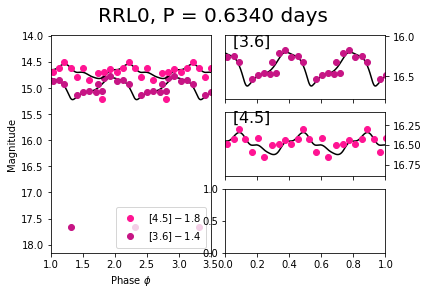

GLOESSpy results for P = 0.63395325:

mean_mag_ch1 = 16.391331
amplitude_ch1 = 0.42312555
sdev_ch1 = 0.1340133
mean_mag_ch2 = 16.490385
amplitude_ch2 = 0.27596817
sdev_ch2 = 0.081941922

mean_unc_ch1 = 0.038413673
mean_unc_ch2 = 0.050795333


RRL Catalogue ID: 1

Failed to find significant match to Gaia DR2 variable database: using catalogue stars.

Channel 1 MAIN_ID: 1
GAIA ID: 2814894112367752192

Channel 2 MAIN_ID: 1
GAIA ID: 2814894112367752192

RRL1  ---- Period = 0.5971 days
------------------------------------------------------
12 11
[16.30470397 16.34960007 16.20665562 16.20283825 16.13265181 16.15826987
 16.23054787 16.28951031 16.29557119 16.27435791 16.33339792 16.35016254]
(12,)
[0.83409424 0.93855622 0.04248935 0.14592186 0.25686557 0.34458236
 0.44802078 0.55481628 0.65292422 0.75305679 0.85857856 0.95950503]
(12,)
<[3.6]> = 16.248    std dev = 0.062     amplitude = 0.191
[16.59450515 16.24935895 16.53254323 16.09205299 16.13394617 16.38275066
 16.54596264 16.08911335 16.

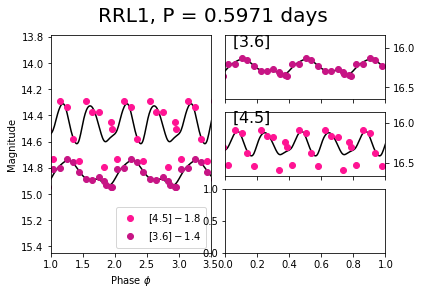

GLOESSpy results for P = 0.5971:

mean_mag_ch1 = 16.24778
amplitude_ch1 = 0.19128954
sdev_ch1 = 0.062128977
mean_mag_ch2 = 16.269347
amplitude_ch2 = 0.30533217
sdev_ch2 = 0.10174723

mean_unc_ch1 = 0.026432236
mean_unc_ch2 = 0.037348509


RRL Catalogue ID: 2

Gaia source_id = 2814893910504601600

RRL classification: RRab

Channel 1 MAIN_ID: 2
GAIA ID: 2814893910504601600

Channel 2 MAIN_ID: 2
GAIA ID: 2814893910504601600

RRL2  ---- Period = 0.5782076389734139 days
------------------------------------------------------
12 12
[16.2734431  16.42650417 16.26376238 19.15419625 16.17713817 16.13669131
 16.21871735 16.28934073 16.26317716 16.47955286 16.6129179  16.50197267]
(12,)
[0.9136416  0.02151677 0.12884581 0.23565787 0.35022656 0.4408094
 0.54762757 0.6579125  0.75922603 0.86263033 0.97159992 0.07582406]
(12,)
<[3.6]> = 16.345    std dev = 0.119     amplitude = 0.407
[16.65032306 16.68133129 16.47972021 16.4073928  16.40398438 16.31397071
 16.16419847 16.62104394 16.49300172 16.23709

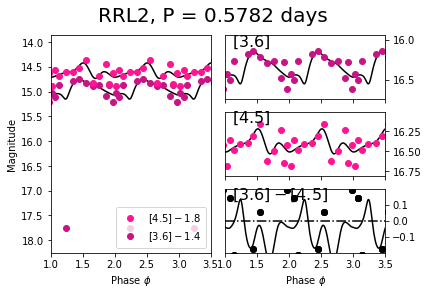

GLOESSpy results for P = 0.57820764:

mean_mag_ch1 = 16.344797
amplitude_ch1 = 0.40739739
sdev_ch1 = 0.11887714
mean_mag_ch2 = 16.411298
amplitude_ch2 = 0.31345658
sdev_ch2 = 0.085265255

mean_unc_ch1 = 0.040115183
mean_unc_ch2 = 0.04927158


RRL Catalogue ID: 3

Gaia source_id = 2811888666052959232

RRL classification: RRab

Channel 1: No match found to main photometry file. Select different channel.

Channel 2 MAIN_ID: 3
GAIA ID: 2811888666052959232

RRL3  ---- Period = 0.5753486184073174 days
------------------------------------------------------
0 12
[16.23929533 16.25047413 16.38540976 16.33633678 16.4296276  16.52105091
 16.60911666 16.67611695 16.49615313 16.50233814 16.40652867 16.48136274]
(12,)
[0.69196218 0.8003734  0.90823578 0.01557861 0.13071662 0.22174959
 0.32909855 0.43993152 0.54174849 0.64566662 0.7551777  0.85991975]
(12,)
<[4.5]> = 16.462    std dev = 0.105     amplitude = 0.313


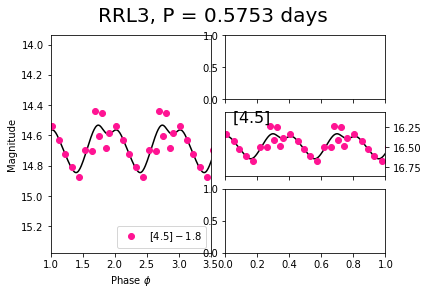

GLOESSpy results for P = 0.57534862:

mean_mag_ch1 = nan
amplitude_ch1 = nan
sdev_ch1 = nan
mean_mag_ch2 = 16.461921
amplitude_ch2 = 0.3132421
sdev_ch2 = 0.1048976

mean_unc_ch1 = nan
mean_unc_ch2 = 0.030750335


Channel 1 results:
Average Mags:
[16.37133089 16.22777955 16.32479655]
Average Uncertainty (Mag):
[0.03841367 0.02643224 0.04011518]
Period:
[0.10205723 0.07604707 0.06208383]

Channel 2 results:
Average Mags:
[16.4743845  16.25334723 16.39529818 16.44592106]
Average Uncertainty (Mag):
[0.05079533 0.03734851 0.04927158 0.03075034]
Period:
[0.10205723 0.07604707 0.06208383 0.05993107]



In [90]:
## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL13/PAL13_RRL_data_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL13/PAL13_RRL_data_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL13 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL13_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia - Variable stars around 10 arcmin of {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec', 'parallax'])

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LISTS FOR USE IN PL RELATIONS ##

av_mag1 = []
av_mag2 = []
av_unc1 = []
av_unc2 = []
av_std1 = []
av_std2 = []
period1 = []
period2 = []

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat) - 1):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)
    rad = 0.25 * u.arcmin
    
    ## CHECK SIGNIFICANT MATCH TO GAIA DATA AROUND CLUSTER ##
    # THIS IS TO ENSURE WHETHER A GAIA PERIOD CAN BE USED OR A MANUAL
    # FIRST STATEMENT DEALS WITH SIGNIFICANT MATCHES
    # SECOND STATEMENT DEALS WITH USER INPUT PERIODS
    
    if (d2d < rad):
        
        gaia_source = gaia_data[source_id]['source_id']
        print('Gaia source_id = {0}\n'.format(gaia_source))
        
        ## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

        vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
        votable = parse_single_table(vot_file1).to_table()
        gaia_main = votable

        ## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

        for idx in range(len(gaia_main)):
            if gaia_main[idx]['source_id'] == gaia_source:
                main_id = idx
        if gaia_main[main_id]['source_id'] != gaia_source:
            print('No match in DR2 variable stars!\n')
            print(gaia_source)
            print(gaia_main[main_id]['source_id'])
            print('Manual period required.\n')

        ## EXTRACT PERIODS FROM GAIA DATA ##
        # IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE OR BOTH
        # IF RRd TYPE THEN PLOTTING BOTH LIGHT CURVES REQUIRED
            # FIRST LEVEL EXTRACTS BOTH PERIODS, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
                # PLOTS BOTH LIGHT CURVES AND ASKS USER INPUT AS TO WHICH LIGHT CURVE DATA TO ADD TO PL FIT LISTS
        # IF NOT RRd TYPE THEN JUST ONE LIGHT CURVE NEEDED
            # FIRST LEVEL EXTRACTS THE PERIOD, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
            # ADDS DATA FOR EACH CHANNEL (WHERE POSSIBLE) TO PL FIT LISTS

        if gaia_main[main_id]['best_classification'] == b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                P0 = gaia_main[main_id]['pf']
                P0_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                P1 = gaia_main[main_id]['p1_o']
                P1_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL has two periods: P0 = {0:.8g} and P1 = {1:.8g}\n'.format(P0, P1))
            
            rrl_class = 'RRd'

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##
            
            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.array(unc1)
            unc2 = np.array(unc2)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1) != 0:
                for i in range(len(unc1)):
                    av_unc1_inter += unc1[i]
                av_unc1_inter = av_unc1_inter / len(unc1)
            elif len(unc1) == 0:
                av_unc1_inter = float('NaN')
            
            for i in range(len(unc2)):
                av_unc2_inter += unc2[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2)

            av_1a, am_1a, sd_1a, av_2a, am_2a, sd_2a = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P0, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P0 = {0:.8g}:\n'.format(P0))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1a, am_1a, sd_1a, av_2a, am_2a, sd_2a))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            av_1b, am_1b, sd_1b, av_2b, am_2b, sd_2b = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P1, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P1 = {0:.8g}:\n'.format(P1))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1b, am_1b, sd_1b, av_2b, am_2b, sd_2b))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
            if rrl_class == 'RRd':
                P1 = np.log10(P1) + 0.127 + 0.3
            
            while True:
                print('Select which Period provides the most clarity: 1 or 2\n')
                sel = int(input())
                
                ## EXTRACTING THE VALUES FOR THE BEST LIGHT CURVE ##
                if sel == 1:
                    if np.isnan(av_1a) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1a)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1a)
                        period1.append(P1)
                        
                    av_mag2.append(av_2a)
                    av_unc2.append(av_unc2_inter)
                    av_std2.append(sd_2a)
                    period2.append(P1)
                elif sel == 2:
                    if np.isnan(av_1b) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1b)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1b)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1b)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1b)
                        period1.append(P1)
                        
                    av_mag2.append(av_2b)
                    av_unc2.append(av_unc2_inter)
                    av_std2.append(sd_2a)
                    period2.append(P1)
                break
            
        elif gaia_main[main_id]['best_classification'] != b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                rrl_class = 'RRab'
                P = gaia_main[main_id]['pf']
                P_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                rrl_class = 'RRc'
                P = gaia_main[main_id]['p1_o']
                P_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL classification: {0}\n'.format(rrl_class))

            ## USE PERIOD FROM CHRISTINE'S CATALOGUE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED ##
            if gaia_main[main_id]['source_id'] != gaia_source:
                P = rrl_cat['period'][target_rrl]

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.ma.array(unc1)
            unc1 = np.ma.masked_where(unc1 == 99., unc1)
            unc2 = np.ma.array(unc2)
            unc2 = np.ma.masked_where(unc2 == 99., unc2)

            unc1_ma = []
            unc2_ma = []

            for i in range(len(unc1)):
                if type(unc1[i]) != np.ma.core.MaskedConstant:
                    unc1_ma.append(unc1[i])
            for i in range(len(unc2)):
                if type(unc2[i]) != np.ma.core.MaskedConstant:
                    unc2_ma.append(unc2[i])

            unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1_ma) != 0:
                for i in range(len(unc1_ma)):
                    av_unc1_inter += unc1_ma[i]
                av_unc1_inter = av_unc1_inter / len(unc1_ma)
            elif len(unc1_ma) == 0:
                av_unc1_inter = float('NaN')                    
          
            for i in range(len(unc2_ma)):
                av_unc2_inter += unc2_ma[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2_ma)

            av_1, am_1, sd_1, av_2, am_2, sd_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1, am_1, sd_1, av_2, am_2, sd_2))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD NEEDS TO BE FUNDAMENTALISED ##
            if rrl_class == 'RRab':
                P = np.log10(P) + 0.3
            elif rrl_class == 'RRc':
                P = np.log10(P) + 0.127 + 0.3
            
            ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##
            if np.isnan(av_1) == True:
                P1 = float('nan')
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                av_std1.append(sd_1)
                period1.append(P1)
            else:
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                av_std1.append(sd_1)
                period1.append(P)
                        
            av_mag2.append(av_2)
            av_unc2.append(av_unc2_inter)
            av_std2.append(sd_2)
            period2.append(P)
    else:
        print('Failed to find significant match to Gaia DR2 variable database: using catalogue stars.\n')
        P = rrl_cat['period'][target_rrl]
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
        main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
        if (d2d > 0.5 * u.arcmin):
            multi = 0 # STAR NOT IN BOTH CHANNELS
            print('Channel 1: No match found to main photometry file. Select different channel.\n')
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
        else:
            multi = 1 # STAR IS IN BOTH CHANNELS
            print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
        ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
        main_table1_m = copy.copy(main_table1.filled(99))
        main_table2_m = copy.copy(main_table2.filled(99))

        mag1 = []
        unc1 = []
        mag2 = []
        unc2 = []

        for i in range(1, 13):
            if multi == 1:
                mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
            if (multi == 0 or multi == 1):
                mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])
        
        unc1 = np.ma.array(unc1)
        unc1 = np.ma.masked_where(unc1 == 99., unc1)
        unc2 = np.ma.array(unc2)
        unc2 = np.ma.masked_where(unc2 == 99., unc2)

        unc1_ma = []
        unc2_ma = []

        for i in range(len(unc1)):
            if type(unc1[i]) != np.ma.core.MaskedConstant:
                unc1_ma.append(unc1[i])
        for i in range(len(unc2)):
            if type(unc2[i]) != np.ma.core.MaskedConstant:
                unc2_ma.append(unc2[i])

        unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
        av_unc1_inter, av_unc2_inter = 0, 0
            
        if len(unc1_ma) != 0:
            for i in range(len(unc1_ma)):
                av_unc1_inter += unc1_ma[i]
            av_unc1_inter = av_unc1_inter / len(unc1_ma)
        elif len(unc1_ma) == 0:
            av_unc1_inter = float('NaN')
            
        for i in range(len(unc2_ma)):
            av_unc2_inter += unc2_ma[i]
                
        av_unc2_inter = av_unc2_inter / len(unc2_ma)

        av_1, am_1, sd_1, av_2, am_2, sd_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
        print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
        print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1, am_1, sd_1, av_2, am_2, sd_2))
        print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
        ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
        if rrl_cat['type'][target_rrl] == 'RR0':
            P = np.log10(P) + 0.3
        elif rrl_cat['type'][target_rrl] == 'RR1':
            P = np.log10(P) + 0.127 + 0.3
        
        ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##

        if np.isnan(av_1) == True:
            P1 = float('nan')
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            av_std1.append(sd_1)
            period1.append(P1)
        else:
            P1 = P
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            av_std1.append(sd_1)
            period1.append(P1)
                        
        av_mag2.append(av_2)
        av_unc2.append(av_unc2_inter)
        av_std2.append(sd_2)
        period2.append(P)
        
## REMOVING NANS FROM RESULTS ##

av_mag1, av_unc1, av_std1, period1 = np.array(av_mag1), np.array(av_unc1), np.array(av_std1), np.array(period1)
av_mag2, av_unc2, av_std2, period2 = np.array(av_mag2), np.array(av_unc2), np.array(av_std2), np.array(period2)

def NaNmask(data):
    mask = ~np.isnan(data)
    result = data[mask]
    return result

av_mag1 = NaNmask(av_mag1)
av_unc1 = NaNmask(av_unc1)
av_mag2 = NaNmask(av_mag2)
av_unc2 = NaNmask(av_unc2)
av_std1 = NaNmask(av_std1)
av_std2 = NaNmask(av_std2)
period1 = NaNmask(period1)
period2 = NaNmask(period2)

## EXTINCTION CORRECTION ##
# NOTE: AS STARS OCCUPY AREA OF LOWER RESOLUTION THAN DUST MAP (CHECKED), FUNCTION WILL AUTO SUBTRACT THE FINAL EXT. VALUE
def extinction_corr(star_table, data1, data2):
    stars = star_table
    for i in range(len(stars)):
        ra = stars['ra_deg'][i]
        dec = stars['dec_deg'][i]
        #print('Coords: ra = {0} d, dec = {1} d\n'.format(ra, dec))
        c = SkyCoord(ra, dec, unit = u.degree, frame = 'icrs')
        table = IrsaDust.get_extinction_table(c)
        irac1_ext = table[19][3]
        irac2_ext = table[20][3]

    data_in1 = data1
    data_in2 = data2
    data_out1 = data_in1 - irac1_ext
    data_out2 = data_in2 - irac2_ext
    return data_out1, data_out2

av_mag1, av_mag2 = extinction_corr(rrl_cat, av_mag1, av_mag2)

print('Channel 1 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag1,av_unc1,period1))
print('Channel 2 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag2,av_unc2,period2))

##### Redo GLOESS clean

Gaia - Variable stars around 10 arcmin of PAL13:

     source_id              ra                dec                parallax      
                           deg                deg                  mas         
------------------- ------------------ ------------------ ---------------------
2814893910504601600 346.67978677468676 12.779806430061193  -0.10865680643084175
2814894112367752192 346.67311058250334  12.78290688815221   -0.3612801745128691
2811888666052959232  346.7035694269076 12.689666115014036 -0.062453203070270635
RR Lyrae catalogue for PAL13:

   id           ra          dec  period type   ra_deg  dec_deg
0   0  23:06:41.53  +12:46:58.9  0.5382  RR0  346.673  12.7830
1   1  23:06:44.47  +12:46:16.1  0.5971  RR0  346.685  12.7711
2   2  23:06:43.14  +12:46:47.8  0.5782  RR0  346.680  12.7799
3   3  23:06:48.83  +12:41:22.3  0.5751  RR0  346.703  12.6895
4   4  23:06:37.28  +12:49:27.5  7.2600  RR0  346.655  12.8243


RRL Catalogue ID: 0

Channel 1 MAIN_ID: 0
GAIA ID: 28118886

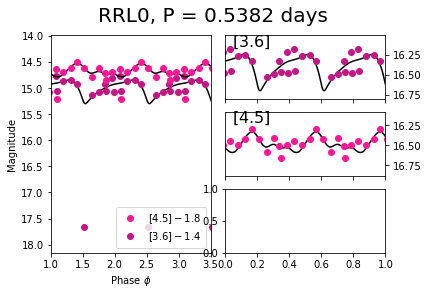

GLOESSpy results for P = 0.5382:

mean_mag_ch1 = 16.408324
amplitude_ch1 = 0.45555884
sdev_ch1 = 0.13474109
mean_mag_ch2 = 16.482918
amplitude_ch2 = 0.25864709
sdev_ch2 = 0.075461014

mean_unc_ch1 = 0.038413673
mean_unc_ch2 = 0.050795333


RRL Catalogue ID: 1

Channel 1 MAIN_ID: 1
GAIA ID: 2811888666052959232

Channel 2 MAIN_ID: 1
GAIA ID: 2811888666052959232

RRL1  ---- Period = 0.5971 days
------------------------------------------------------
12 11
[16.30470397 16.34960007 16.20665562 16.20283825 16.13265181 16.15826987
 16.23054787 16.28951031 16.29557119 16.27435791 16.33339792 16.35016254]
(12,)
[0.83409424 0.93855622 0.04248935 0.14592186 0.25686557 0.34458236
 0.44802078 0.55481628 0.65292422 0.75305679 0.85857856 0.95950503]
(12,)
<[3.6]> = 16.248    std dev = 0.062     amplitude = 0.191
[16.59450515 16.24935895 16.53254323 16.09205299 16.13394617 16.38275066
 16.54596264 16.08911335 16.17450109 16.17475069 99.         16.30632756]
(12,)
[0.83409424 0.93855622 0.04248935 0.145

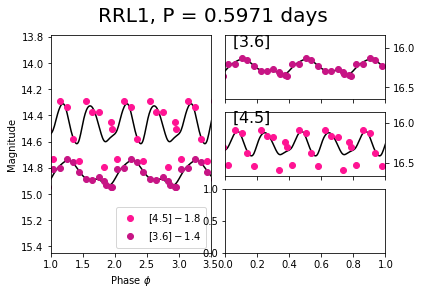

GLOESSpy results for P = 0.5971:

mean_mag_ch1 = 16.24778
amplitude_ch1 = 0.19128954
sdev_ch1 = 0.062128977
mean_mag_ch2 = 16.269347
amplitude_ch2 = 0.30533217
sdev_ch2 = 0.10174723

mean_unc_ch1 = 0.026432236
mean_unc_ch2 = 0.037348509


RRL Catalogue ID: 2

Channel 1 MAIN_ID: 2
GAIA ID: 2811888666052959232

Channel 2 MAIN_ID: 2
GAIA ID: 2811888666052959232

RRL2  ---- Period = 0.5782 days
------------------------------------------------------
12 12
[16.2734431  16.42650417 16.26376238 19.15419625 16.17713817 16.13669131
 16.21871735 16.28934073 16.26317716 16.47955286 16.6129179  16.50197267]
(12,)
[0.20518449 0.31306109 0.42039155 0.52720502 0.64177522 0.73235927
 0.83917884 0.94946523 0.0507801  0.15418576 0.26315679 0.36738231]
(12,)
<[3.6]> = 16.345    std dev = 0.119     amplitude = 0.407
[16.65032306 16.68133129 16.47972021 16.4073928  16.40398438 16.31397071
 16.16419847 16.62104394 16.49300172 16.23709048 16.41758031 16.3603971 ]
(12,)
[0.20518449 0.31306109 0.42039155 0.5272

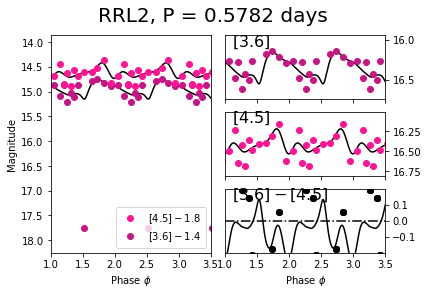

GLOESSpy results for P = 0.5782:

mean_mag_ch1 = 16.344796
amplitude_ch1 = 0.40693966
sdev_ch1 = 0.11887974
mean_mag_ch2 = 16.411299
amplitude_ch2 = 0.31341549
sdev_ch2 = 0.085265878

mean_unc_ch1 = 0.040115183
mean_unc_ch2 = 0.04927158


RRL Catalogue ID: 3

Channel 1: No match found to main photometry file. Select different channel.

Channel 2 MAIN_ID: 3
GAIA ID: 2811888666052959232

RRL3  ---- Period = 0.5751 days
------------------------------------------------------
0 12
[16.23929533 16.25047413 16.38540976 16.33633678 16.4296276  16.52105091
 16.60911666 16.67611695 16.49615313 16.50233814 16.40652867 16.48136274]
(12,)
[0.16316758 0.27162567 0.37953468 0.48692391 0.60211169 0.69318402
 0.80057939 0.91146027 0.01332125 0.11728431 0.22684274 0.33163007]
(12,)
<[4.5]> = 16.462    std dev = 0.105     amplitude = 0.313


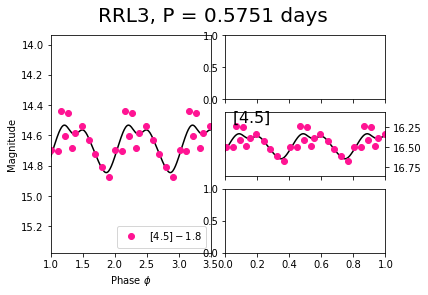

GLOESSpy results for P = 0.5751:

mean_mag_ch1 = nan
amplitude_ch1 = nan
sdev_ch1 = nan
mean_mag_ch2 = 16.461938
amplitude_ch2 = 0.31343788
sdev_ch2 = 0.10490336

mean_unc_ch1 = nan
mean_unc_ch2 = 0.030750335


Channel 1 results:
Average Mags:
[16.38832413 16.22777955 16.32479629]
Average Uncertainty (Mag):
[0.03841367 0.02643224 0.04011518]
Period:
[0.03094369 0.07604707 0.06207809]

Channel 2 results:
Average Mags:
[16.46691781 16.25334723 16.39529851 16.4459377 ]
Average Uncertainty (Mag):
[0.05079533 0.03734851 0.04927158 0.03075034]
Period:
[0.03094369 0.07604707 0.06207809 0.05974337]



In [91]:
## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL13/PAL13_RRL_data_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL13/PAL13_RRL_data_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL13 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL13_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia - Variable stars around 10 arcmin of {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec', 'parallax'])

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LISTS FOR USE IN PL RELATIONS ##

av_mag1 = []
av_mag2 = []
av_unc1 = []
av_unc2 = []
av_std1 = []
av_std2 = []
period1 = []
period2 = []

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat) - 1):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    ## PERIOD OF STAR FROM CATALOGUE ##
    P = rrl_cat['period'][target_rrl]
    
    ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

    main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
    main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
    
    if (d2d > 0.5 * u.arcmin):
        multi = 0 # STAR NOT IN BOTH CHANNELS
        print('Channel 1: No match found to main photometry file. Select different channel.\n')
        print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
    else:
        multi = 1 # STAR IS IN BOTH CHANNELS
        print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
        print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
        
    ## FILL TABLE WITH DUMMY INTS FOR GLOESS ##
    
    main_table1_m = copy.copy(main_table1.filled(99))
    main_table2_m = copy.copy(main_table2.filled(99))

    mag1 = []
    unc1 = []
    mag2 = []
    unc2 = []

    for i in range(1, 13):
        if multi == 1:
            mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
            unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
        if (multi == 0 or multi == 1):
            mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
            unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])
        
    unc1 = np.ma.array(unc1)
    unc1 = np.ma.masked_where(unc1 == 99., unc1)
    unc2 = np.ma.array(unc2)
    unc2 = np.ma.masked_where(unc2 == 99., unc2)

    unc1_ma = []
    unc2_ma = []

    for i in range(len(unc1)):
        if type(unc1[i]) != np.ma.core.MaskedConstant:
            unc1_ma.append(unc1[i])
    for i in range(len(unc2)):
        if type(unc2[i]) != np.ma.core.MaskedConstant:
            unc2_ma.append(unc2[i])

    unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
    av_unc1_inter, av_unc2_inter = 0, 0
            
    if len(unc1_ma) != 0:
        for i in range(len(unc1_ma)):
            av_unc1_inter += unc1_ma[i]
        av_unc1_inter = av_unc1_inter / len(unc1_ma)
    elif len(unc1_ma) == 0:
        av_unc1_inter = float('NaN')
            
    for i in range(len(unc2_ma)):
        av_unc2_inter += unc2_ma[i]
                
    av_unc2_inter = av_unc2_inter / len(unc2_ma)

    av_1, am_1, sd_1, av_2, am_2, sd_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
        
    print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
    print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1, am_1, sd_1, av_2, am_2, sd_2))
    print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
    
    ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
    if rrl_cat['type'][target_rrl] == 'RR0':
        P = np.log10(P) + 0.3
    elif rrl_cat['type'][target_rrl] == 'RR1':
        P = np.log10(P) + 0.127 + 0.3
        
    ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##

    if np.isnan(av_1) == True:
        P1 = float('nan')
        av_mag1.append(av_1)
        av_unc1.append(av_unc1_inter)
        av_std1.append(sd_1)
        period1.append(P1)
    else:
        P1 = P
        av_mag1.append(av_1)
        av_unc1.append(av_unc1_inter)
        av_std1.append(sd_1)
        period1.append(P1)
        
    av_mag2.append(av_2)
    av_unc2.append(av_unc2_inter)
    av_std2.append(sd_2)
    period2.append(P)
    
## REMOVING NANS FROM RESULTS ##


av_mag1, av_unc1, av_std1, period1 = np.array(av_mag1), np.array(av_unc1), np.array(av_std1), np.array(period1)
av_mag2, av_unc2, av_std2, period2 = np.array(av_mag2), np.array(av_unc2), np.array(av_std2), np.array(period2)

def NaNmask(data):
    mask = ~np.isnan(data)
    result = data[mask]
    return result

av_mag1 = NaNmask(av_mag1)
av_unc1 = NaNmask(av_unc1)
av_mag2 = NaNmask(av_mag2)
av_unc2 = NaNmask(av_unc2)
av_std1 = NaNmask(av_std1)
av_std2 = NaNmask(av_std2)
period1 = NaNmask(period1)
period2 = NaNmask(period2)

## EXTINCTION CORRECTION ##
# NOTE: AS STARS OCCUPY AREA OF LOWER RESOLUTION THAN DUST MAP (CHECKED), FUNCTION WILL AUTO SUBTRACT THE FINAL EXT. VALUE
def extinction_corr(star_table, data1, data2):
    stars = star_table
    for i in range(len(stars)):
        ra = stars['ra_deg'][i]
        dec = stars['dec_deg'][i]
        #print('Coords: ra = {0} d, dec = {1} d\n'.format(ra, dec))
        c = SkyCoord(ra, dec, unit = u.degree, frame = 'icrs')
        table = IrsaDust.get_extinction_table(c)
        irac1_ext = table[19][3]
        irac2_ext = table[20][3]

    data_in1 = data1
    data_in2 = data2
    data_out1 = data_in1 - irac1_ext
    data_out2 = data_in2 - irac2_ext
    return data_out1, data_out2

av_mag1, av_mag2 = extinction_corr(rrl_cat, av_mag1, av_mag2)

print('Channel 1 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag1,av_unc1,period1))
print('Channel 2 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag2,av_unc2,period2))

##### Fit PL relations

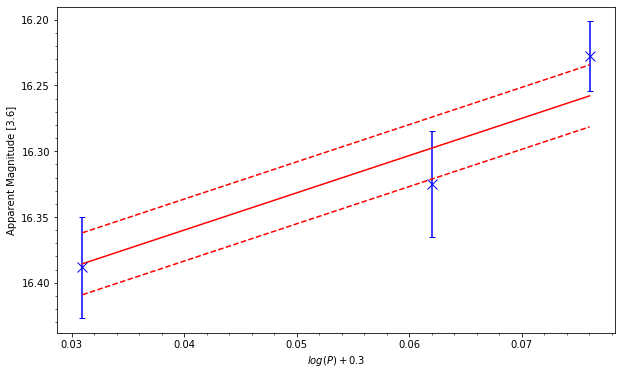

Intercept a₂             = 16.47 ± 0.02
Distance modulus a₂ - a₁ = 16.88 ± 0.03 (random) ± 0.12 (systematic)
Distance to PAL13        = 23.8 ± 0.38 (random) ± 1.32 (systematic) kpc


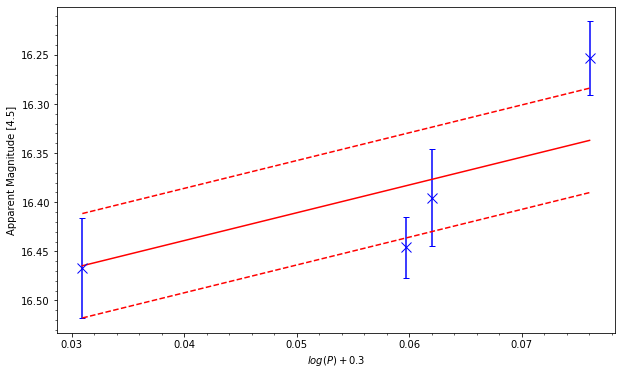

Intercept a₂             = 16.55 ± 0.03
Distance modulus a₂ - a₁ = 16.96 ± 0.04 (random) ± 0.12 (systematic)
Distance to PAL13        = 24.69 ± 0.49 (random) ± 1.37 (systematic) kpc


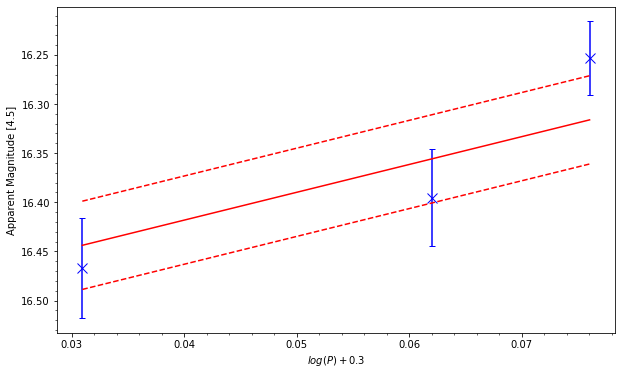

Intercept a₂             = 16.53 ± 0.03
Distance modulus a₂ - a₁ = 16.94 ± 0.04 (random) ± 0.12 (systematic)
Distance to PAL13        = 24.45 ± 0.49 (random) ± 1.36 (systematic) kpc


In [92]:
## FIT PARAMETERS ##

if (channel == 1) or (channel == '3p6um'):
    a1     = -0.40    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.78
    b_unc  = 0.38
if (channel == 2) or (channel == '4p5um'):
    a1     = -0.41    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.83
    b_unc  = 0.39

## FUNCTIONS FOR FIT AND DISTANCE ##

def func(P, intercept):
    return intercept + b * P

def distance(a1, a2):
    a1 = a1
    a2 = a2
    d = 10 ** (1 + (a2 - a1) / 5)
    return d

##_________________##
## FIT : CHANNEL 1 ##

channel = '3p6um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period1, av_mag1)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev1 = 0
for i in range(len(av_mag1)):
    std_dev1 += (av_mag1[i] - (a2 + b * period1[i]))**2
std_dev1 = np.sqrt(std_dev1 / len(av_mag1))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period1, av_mag1, xerr = None, yerr = av_unc1, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Apparent Magnitude [3.6]')
x = np.linspace(min(period1), max(period1), 100)
y = np.linspace(min(period1), max(period1), 100)
ax.plot(y, y * b + (a2 + std_dev1), linestyle = '--', color = 'red')
ax.plot(y, y * b + (a2 - std_dev1), linestyle = '--', color = 'red')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
#plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
#plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
#plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(a2, a2_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}        = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##_________________##
## FIT : CHANNEL 2 ##

channel = '4p5um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period2, av_mag2)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev2 = 0
for i in range(len(av_mag2)):
    std_dev2 += (av_mag2[i] - (a2 + b * period2[i]))**2
std_dev2 = np.sqrt(std_dev2 / len(av_mag2))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period2, av_mag2, xerr = None, yerr = av_unc2, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Apparent Magnitude [4.5]')
x = np.linspace(min(period2), max(period2), 100)
y = np.linspace(min(period2), max(period2), 100)
ax.plot(y, y * b + (a2 + std_dev2), linestyle = '--', color = 'red')
ax.plot(y, y * b + (a2 - std_dev2), linestyle = '--', color = 'red')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
#plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
#plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
#plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(a2, a2_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}        = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##__________________##
## FIT : CHANNEL 2a ##

channel = '4p5um'

## OBTAIN STARS COMMON TO BOTH CHANNELS ##

period3 = []
av_mag3 = []
av_unc3 = []

for i in range(len(period2)):
    for j in range(len(period1)):
        if period1[[j]] == period2[[i]]:
            period3.append(period1[j])
            av_mag3.append(av_mag2[i])
            av_unc3.append(av_unc2[i])

av_mag3, av_unc3, period3 = np.array(av_mag3), np.array(av_unc3), np.array(period3)

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period3, av_mag3)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev3 = 0
for i in range(len(av_mag3)):
    std_dev3 += (av_mag3[i] - (a2 + b * period3[i]))**2
std_dev3 = np.sqrt(std_dev3 / len(av_mag3))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period3, av_mag3, xerr = None, yerr = av_unc3, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Apparent Magnitude [4.5]')
x = np.linspace(min(period3), max(period3), 100)
y = np.linspace(min(period3), max(period3), 100)
ax.plot(y, y * b + (a2 + std_dev3), linestyle = '--', color = 'red')
ax.plot(y, y * b + (a2 - std_dev3), linestyle = '--', color = 'red')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
#plt.title('{0} PL relation: channel {1} (channel 1 stars)'.format(cluster, channel))
plt.minorticks_on()
#plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
#plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)+'ch1_combined_ch2'
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(a2, a2_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}        = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))